In [1]:
import yaml

with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

N = config["rnn"]["simulation"]["N"]
timesteps = config["rnn"]["simulation"]["timesteps"]
dt = config["rnn"]["simulation"]["dt"]
alpha = config["rnn"]["simulation"]["alpha"]
beta = config["rnn"]["simulation"]["beta"]

seed = config["rnn"]["model"]["seed"]
train_size = config["rnn"]["model"]["train_size"]
val_size = config["rnn"]["model"]["val_size"]
test_size = config["rnn"]["model"]["test_size"]
window_size = config["rnn"]["model"]["window_size"]

loss = config["rnn"]["training"]["loss"]

In [2]:
import numpy as np
from functions import Simulation as SIM
from functions import MachineLearning as ML
import os

# Specify the folder path
folder_path = r"D:/School/Magistrska/data"

q_i = np.sin(np.linspace(0, np.pi*2, N))
p_i = np.zeros(N)

sim = SIM(q_i, p_i, N, timesteps, dt)

# Check if the folder is empty
if len(os.listdir(folder_path)) == 0:
    print("No saved data, running simulation.")

    qs, ps = sim.integrate(alpha, beta)
    
else:
    print("Found some saved data, skipping simulation.")
    
    qs = np.load(folder_path+"\data_qs_1.npy")
    ps = np.load(folder_path+"\data_ps_1.npy")
    
qs = qs[:, 1:-1]
ps = ps[:, 1:-1]

In [3]:
ml = ML(qs, ps, window_size, train_size, val_size, test_size)
X, y = ml.make_sequences()
X_train, X_test, X_val, y_train, y_test, y_val = ml.make_split()

In [5]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.InputLayer((window_size, N)))
        
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed)

        hp_units = hp.Int('units', min_value=1, max_value=30, step=1)
        # hp_units = hp.Int('units', min_value=2, max_value=4, step=2)
        model.add(keras.layers.GRU(hp_units, activation="tanh", kernel_initializer=initializer))
        
        hp_dropout = hp.Choice('dropout', values=[0.0, 0.02, 0.05, 0.1])
        # hp_dropout = hp.Choice('dropout', values=[0.0])
        
        model.add(keras.layers.Dropout(hp_dropout, seed=seed))
        model.add(keras.layers.Dense(N, kernel_initializer=initializer))
        
        hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.05, 0.01, 0.005])
        # hp_learning_rate = hp.Choice('learning_rate', values=[0.1])
        
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
        model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int('batch_size', min_value=5, max_value=50, step=1),
            **kwargs,
        )

In [6]:
tuner = kt.BayesianOptimization(
    MyHyperModel(),
    objective="mse",
    overwrite=True,
    directory="my_dir",
    project_name="intro_to_kt",
    num_initial_points=None,
    max_trials=100,
    seed=seed
)

# tuner = kt.Hyperband(
    # MyHyperModel(),
    # objective="mse",
    # overwrite=True,
    # directory="my_dir",
    # project_name="intro_to_kt",
# )

In [7]:
tuner.search(X_train, y_train, epochs=70, validation_data=(X_val,y_val), callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=10)])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 100 Complete [00h 00m 07s]

Best mse So Far: 5.229355156188831e-05
Total elapsed time: 00h 20m 15s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 28 and the optimal learning rate for the optimizer
is 0.01.



In [8]:
best_hps.values

{'units': 28, 'dropout': 0.0, 'learning_rate': 0.01, 'batch_size': 32}

In [9]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
19/19 - 0s - loss: 0.4068 - mse: 0.4068
Epoch 2/100
19/19 - 0s - loss: 0.0821 - mse: 0.0821
Epoch 3/100
19/19 - 0s - loss: 0.0344 - mse: 0.0344
Epoch 4/100
19/19 - 0s - loss: 0.0191 - mse: 0.0191
Epoch 5/100
19/19 - 0s - loss: 0.0111 - mse: 0.0111
Epoch 6/100
19/19 - 0s - loss: 0.0076 - mse: 0.0076
Epoch 7/100
19/19 - 0s - loss: 0.0058 - mse: 0.0058
Epoch 8/100
19/19 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 9/100
19/19 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 10/100
19/19 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 11/100
19/19 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 12/100
19/19 - 0s - loss: 0.0028 - mse: 0.0028
Epoch 13/100
19/19 - 0s - loss: 0.0024 - mse: 0.0024
Epoch 14/100
19/19 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 15/100
19/19 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 16/100
19/19 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 17/100
19/19 - 0s - loss: 9.2541e-04 - mse: 9.2541e-04
Epoch 18/100
19/19 - 0s - loss: 7.2232e-04 - mse: 7.2232e-04
Epoch 19/100
19/19 - 0s - loss: 5.2787e

In [10]:
test_pred = np.copy(X_test[0])

for k in range(len(X_test)):
    pred = model.predict(test_pred[np.newaxis, -window_size:], verbose=0)
    test_pred = np.concatenate((test_pred, pred), axis = 0)
    
test_pred = test_pred[window_size:]

In [11]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ML.postprocess(y_test), ML.postprocess(test_pred))
print("MSE = ", mse)

MSE =  0.117997509823194


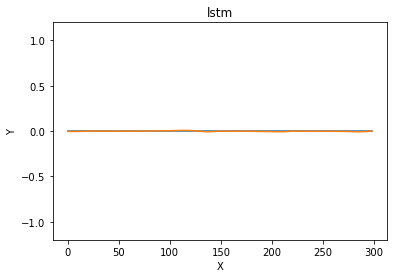

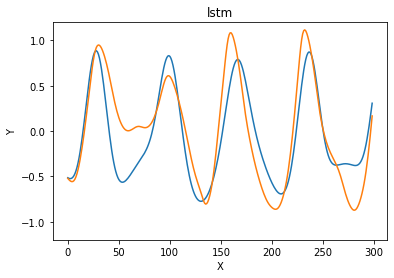

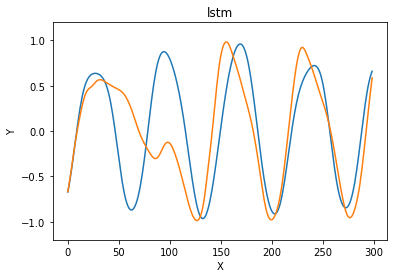

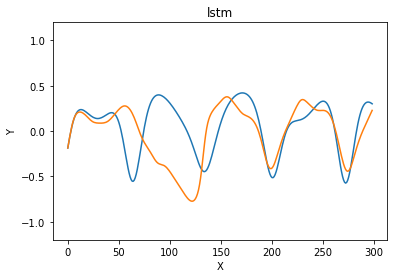

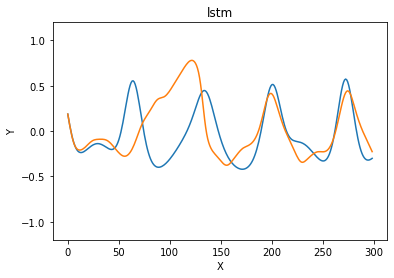

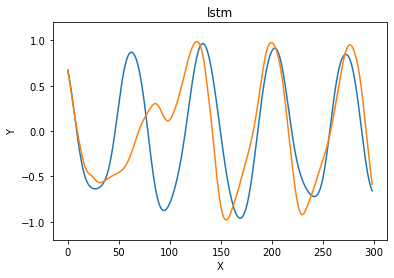

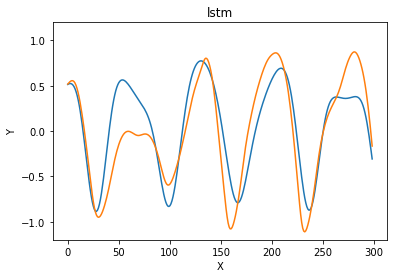

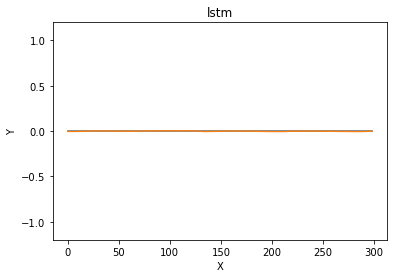

In [12]:
import matplotlib.pyplot as plt

for particles in range(N-2):
    plt.plot(ML.postprocess(y_test)[:, particles], color="tab:blue")
    plt.plot(ML.postprocess(test_pred)[:, particles], color="tab:orange")

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("lstm")
    plt.ylim(-1.2, 1.2)

    # Show the plot
    plt.show()